In [2]:
# Fiji - upland and lowland forest analysis

In [76]:
import dask.array as da
import joblib
import xarray as xr
from dask_ml.wrappers import ParallelPostFit
from datacube.utils.geometry import assign_crs
from xarray import Dataset
from pystac_client import Client
from odc.stac import load
import os
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from rasterio.transform import from_origin
from matplotlib.colors import ListedColormap
from planetary_computer import sign_url
from rasterio.warp import reproject, Resampling

In [4]:
DEP_CATALOG = "https://stac.digitalearthpacific.org"
# DEP_CATALOG = "https://stac.staging.digitalearthpacific.io"
MSPC_CATALOG = "https://planetarycomputer.microsoft.com/api/stac/v1/"

In [5]:
bbox = [177.16629173119162, -18.354349299973833, 179.999999, -16.050585743728993]
chunks={"x": 2048, "y": 2048}

In [6]:
mspc_client = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")

# Get a pystac client for the MSPC
items_dem = list(mspc_client.search(collections=["cop-dem-glo-30"], bbox=bbox).items())


In [7]:
data = load(items_dem, measurements="data",
        bbox=bbox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )

In [8]:
data_dem = load(items_dem, chunks=chunks, groupby="solar_day", like=data, patch_url=sign_url)

In [9]:
data_dem = (data_dem.where(data_dem != -32768).rename({"data": "elevation"}).squeeze("time"))
data_dem

<xarray.Dataset> Size: 339MB
Dimensions:      (latitude: 8295, longitude: 10202)
Coordinates:
  * latitude     (latitude) float64 66kB -16.05 -16.05 -16.05 ... -18.35 -18.35
  * longitude    (longitude) float64 82kB 177.2 177.2 177.2 ... 180.0 180.0
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2021-04-22
Data variables:
    elevation    (latitude, longitude) float32 339MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>

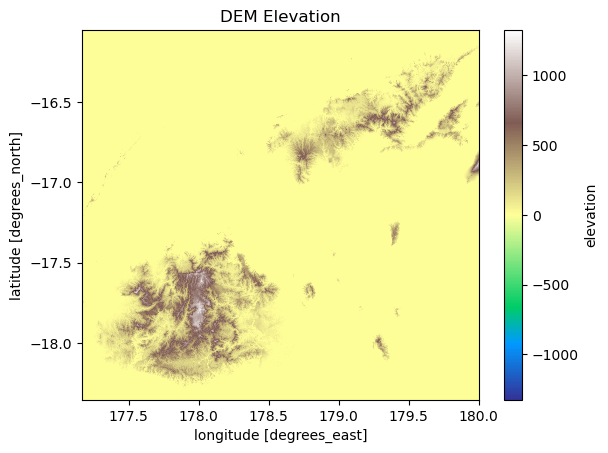

In [10]:
# If you have a DataArray
data_dem['elevation'].plot(cmap='terrain')
plt.title("DEM Elevation")
plt.show()

In [11]:
dem = data_dem['elevation']

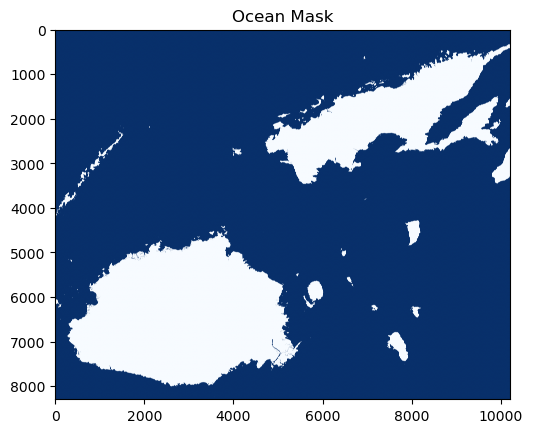

In [12]:
ocean_mask = np.where(dem == 0, 1, 0)  # 1 for ocean, 0 for land

plt.imshow(ocean_mask, cmap='Blues')
plt.title('Ocean Mask')
plt.show()

In [13]:
nodata_value = -9999
dem_nodata = np.where(np.isnan(dem), nodata_value, dem).astype(np.float32)

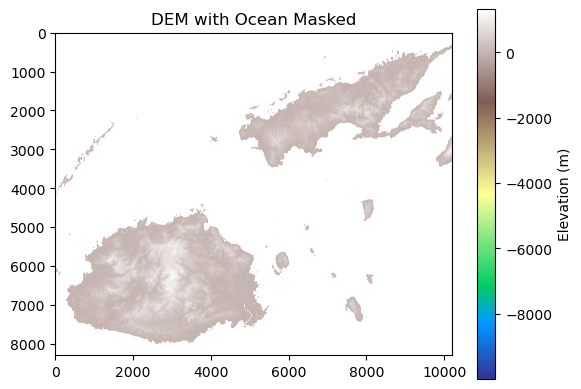

In [14]:
dem_masked = np.where(dem_nodata == 0, np.nan, dem_nodata)

# Example DEM array: ocean cells are np.nan, land is elevation
# dem_masked = np.where(dem_nodata == 0, np.nan, dem_nodata)

cmap = plt.get_cmap('terrain').copy()
cmap.set_bad(color='white')  # set color for ocean (masked np.nan)

im = plt.imshow(dem_masked, cmap=cmap)
plt.title('DEM with Ocean Masked')
cbar = plt.colorbar(im, label='Elevation (m)')

In [15]:
condition_up = (dem_masked>=600)
upland = np.where(condition_up, dem_masked, np.nan)
condition_low = (dem_masked<=600)
lowland = np.where(condition_low, dem_masked, np.nan)

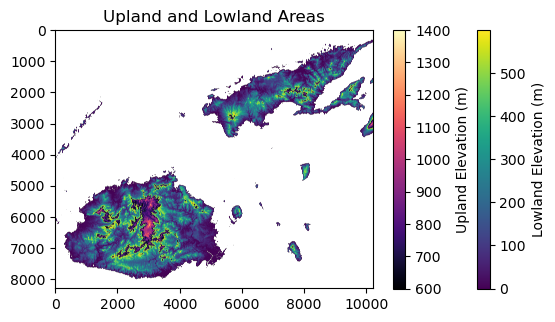

In [16]:
# 1. Set up the plot
fig, ax = plt.subplots()

lowland_min = 0.0
lowland_max = 599.9  # Set max just below the upland threshold
upland_min = 600.0
upland_max = 1400.0 # Set max based on highest possible elevation

# 2. Plot the first array (lowland) with its colormap
im1 = ax.imshow(lowland, cmap='viridis', vmin = lowland_min, vmax=lowland_max)

# 3. Plot the second array (upland) on top with its colormap
# The np.nan values in 'upland' will be transparent, showing 'lowland' below
im2 = ax.imshow(upland, cmap='magma', vmin = upland_min, vmax=upland_max)


# 4. Create separate colorbars for each layer
# We use shrink to make them fit nicely side-by-side
cbar1 = fig.colorbar(im1, ax=ax, shrink=0.7, label='Lowland Elevation (m)')
cbar2 = fig.colorbar(im2, ax=ax, shrink=0.7, label='Upland Elevation (m)')

# 5. Add a title and show the plot
ax.set_title('Upland and Lowland Areas')
plt.show()

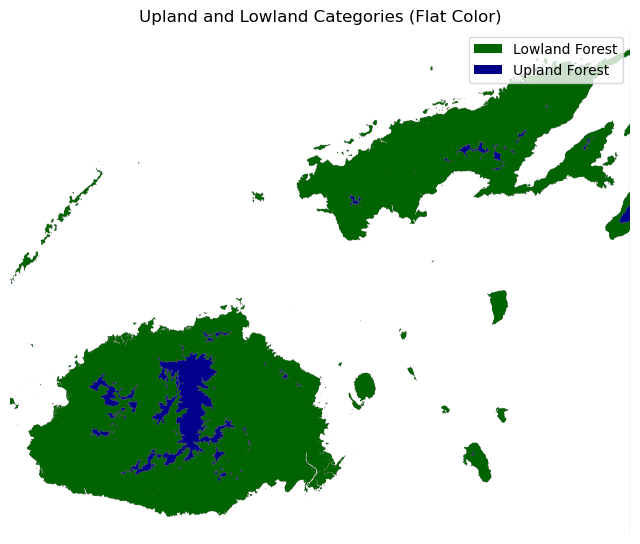

In [17]:
upland_colour = 'darkblue'
lowland_colour = 'darkgreen'


fig, ax = plt.subplots(figsize=(8, 8))

lowland_cmap = ListedColormap([lowland_colour])
upland_cmap = ListedColormap([upland_colour])

dummy_min = np.nanmin(np.concatenate([lowland.flatten(), upland.flatten()])) 
dummy_max = np.nanmax(np.concatenate([lowland.flatten(), upland.flatten()]))

# Plot Lowland first (bottom layer)
im1 = ax.imshow(
    lowland, 
    cmap=lowland_cmap, 
    vmin=dummy_min,  # Use a common scale or just the data min/max
    vmax=dummy_max
)

# Plot Upland second (top layer)
# The transparency from np.nan allows the lowland color to show through
im2 = ax.imshow(
    upland, 
    cmap=upland_cmap, 
    vmin=dummy_min, 
    vmax=dummy_max
)


# 5. Add a Legend (Colorbars are not needed for flat colors, a legend is better)
# You can create a custom legend to show the category names:
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=lowland_colour, label='Lowland Forest'),
    Patch(facecolor=upland_colour, label='Upland Forest')
]

ax.legend(handles=legend_elements, loc='upper right', frameon=True)


# 6. Final adjustments
ax.set_title('Upland and Lowland Categories (Flat Color)')
# Turn off axis labels for a cleaner map view
ax.axis('off') 
plt.show()

In [18]:
height, width = dem_masked.shape
left, right, bottom, top = bbox

pixel_width = (right - left) / width
pixel_height = (top - bottom) / height

transform = from_origin(left, top, pixel_width, pixel_height)  # top left corner

In [25]:
fiji_gfw = rio.open("LossYear_GFW_Fiji.tif")

In [27]:
fiji_gfw.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 18835, 'height': 12662, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026949458523585647, 0.0, 176.78846280169938,
       0.0, -0.00026949458523585647, -15.95920645951665), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [35]:
fiji_gfw_xr = fiji_gfw.read(1)
# fiji_gfw.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [36]:
fiji_gfw_xr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [74]:
mask = (fiji_gfw_xr == 16)
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [75]:
count_sum = np.sum(mask)
count_sum

113186

In [ ]:
dem = rioxarray.open_rasterio("dem.tif")

In [82]:
data_dem.crs

AttributeError: 'Dataset' object has no attribute 'crs'

In [79]:
target_crs = dem.crs
target_transform = dem.transform
target_shape = dem.shape
destination_array = np.empty(target_shape, dtype=src_4326.dtypes[0])


AttributeError: 'DataArray' object has no attribute 'crs'

In [ ]:
# Perform the reprojection
reproject(
    source=rasterio.band(src_4326, 1), # Use band 1 of the 4326 file
    destination=destination_array,
    src_transform=src_4326.transform,
    src_crs=src_4326.crs,
    dst_transform=target_transform,
    dst_crs=target_crs,
    resampling=Resampling.nearest # Use appropriate resampling method
)


In [ ]:
stop

In [ ]:
with rio.open(
    "fj_upland_600m.tif", "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=dem_masked.dtype,
    crs="EPSG:32760",  # update if you know your DEM's CRS is different
    transform=transform,
    nodata=0  # or use -9999 if 0 is valid in your data
) as dst:
    dst.write(upland, 1)

In [ ]:
with rio.open(
    "fj_lowland_600m.tif", "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=dem_masked.dtype,
    crs="EPSG:32760",  # update if you know your DEM's CRS is different
    transform=transform,
    nodata=0  # or use -9999 if 0 is valid in your data
) as dst:
    dst.write(lowland, 1)